In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn
import torch.optim
import torch.utils.data

### Display DataFrame

In [2]:
# Your code here
import pandas as pd
# Google Drive link incase Github link doesn't work
GDrive_Link = "https://drive.google.com/file/d/1ZJP3osriK0isJDyBlyqIhbZ1gvT2N4aH/view?usp=sharing"
print("Google Drive link incase GitHub link doesn't work:")
print(GDrive_Link)

# Import CSV using raw Github link
Github_Link = "https://raw.githubusercontent.com/khangnngo12/Kinematics-of-M33/main/Redshift.csv"
df = pd.read_csv(Github_Link)
print("CSV file containing velocities (km/s), RA, Dec, and other informations:")
df
#raise NotImplementedError()

Google Drive link incase GitHub link doesn't work:
https://drive.google.com/file/d/1ZJP3osriK0isJDyBlyqIhbZ1gvT2N4aH/view?usp=sharing
CSV file containing velocities (km/s), RA, Dec, and other informations:


,Mask Name,Slit Number,RA,DEC,OBJECT ID,Velocity (km/s),QOP
0,M33D2A,29,23.484625,30.428111,215883,-147.0,3
1,M33D2A,49,23.487375,30.453444,238569,-138.0,3
2,M33D2A,50,23.478667,30.454750,238675,-150.0,3
3,M33D2A,53,23.456917,30.461250,245768,-138.0,3
4,M33D2A,54,23.493375,30.461306,246366,-138.0,3
...,...,...,...,...,...,...,...
1683,E2M33R,137,23.478583,30.783306,RGB_64158,-279.0,1
1684,E2M33R,139,23.517458,30.794139,RGB_64530,-249.0,3
1685,E2M33R,154,23.494708,30.808778,RGB_66617,-234.0,3
1686,E2M33R,172,23.666375,30.784944,CFHT254546,-231.0,3


### Display Velocity Map

This section will display the velocity map with a fitted ellipse and two parabolas. The data points are created using RA and Dec, color-coded using its measured H-alpha velocities. The parabolas will divide the map into three areas: North, South, and Center. 

In [3]:
center_RA = (1 + (33/60) + (51.75/3600))*15 #in deg
center_Dec = (30 + (39/60) + (36.630/3600)) # in deg

In [4]:
def linear_func(x,m,b): #y=mx+b function
    return (m*x)+b

In [5]:
def classification_func(RA,Dec):
    
    """
    Function to classified each point into North, South, and Center.
    
    Parameters
    ----------
    RA: ndarray,req
        Containing RA values used in map
    Dec: ndarray, req
        Containing Dec values used in map
        
    Returns
    ----------
    NorthParabola: ndarray containing bools. True == Inside North parabola
    SouthParabola: ndarray containing bools. True == Inside South parabola
    Center: ndarray containing bools. True == Inside Center region
    """
    
    import cmath
    theta = np.radians(-32)
    
    Dec_Val_NP_List = [] #list containing Dec values along North parabola
    Dec_Val_SP_List = [] #list containing Dec values along South parabola
    
    for RA_Val in RA:
    
        # find a,b,c for quadratic formula
        a_NorthPara = -0.5*np.sin(theta)
        b_NorthPara = 0.5*np.cos(theta)
        c_NorthPara = NorthPara_XCoor - RA_Val
        
        a_SouthPara = 0.5*np.sin(theta)
        b_SouthPara = -0.5*np.cos(theta)
        c_SouthPara = SouthPara_XCoor - RA_Val
        
        # calculate the discriminan
        d_NorthPara = (b_NorthPara**2) - (4*a_NorthPara*c_NorthPara) 
        d_SouthPara = (b_SouthPara**2) - (4*a_SouthPara*c_SouthPara)
        
        t_NorthPara = (-b_NorthPara + cmath.sqrt(d_NorthPara))/(2*a_NorthPara) # find t for North Parabola (Notice the plus)
        t_SouthPara = (-b_SouthPara - cmath.sqrt(d_SouthPara))/(2*a_SouthPara) # find t for South Parabola (Notice the subtract)
        
        Dec_Val_NorthPara = 0.5*(t_NorthPara*np.sin(theta) + (t_NorthPara**2)*np.cos(theta)) + NorthPara_YCoor #find corresponding Dec value using t
        Dec_Val_NP_List.append(Dec_Val_NorthPara)
        
        Dec_Val_SouthPara = -0.5*(t_SouthPara*np.sin(theta) + (t_SouthPara**2)*np.cos(theta)) + SouthPara_YCoor
        Dec_Val_SP_List.append(Dec_Val_SouthPara)
        
    NorthParabola = np.array(Dec-np.array(Dec_Val_NP_List) > 0)
    SouthParabola = np.array(Dec-np.array(Dec_Val_SP_List) < 0)
    Center = []
    for index in range(len(RA)):
        if NorthParabola[index] == False:
            if SouthParabola[index] == False:
                Center.append(True)
            else:
                Center.append(False)
        else:
            Center.append(False)
    
    return NorthParabola,SouthParabola,np.array(Center)

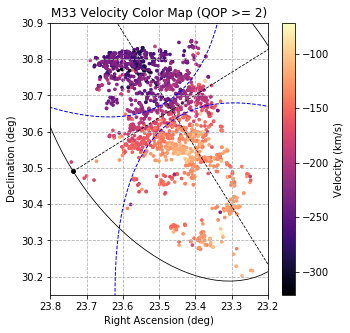

In [6]:
import math
from math import pi, cos, sin

# Get datapoints from CSV files. 
df_qop2_sorted = df["QOP"] >= 2

fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("M33 Velocity Color Map (QOP >= 2)")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect('equal')
cc_map = ax.scatter(df["RA"][df_qop2_sorted]
                    ,df["DEC"][df_qop2_sorted]
                    ,c=df["Velocity (km/s)"][df_qop2_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.grid(True,linestyle="--")

#------------------------------

#Fit Ellipse
u= center_RA       #x-position of the center
v= center_Dec    #y-position of the center
a= 0.52     #radius on the x-axis
b= 0.32      #radius on the y-axis
t_rot=math.radians(58) #rotation angle

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
     #u,v removed to keep the same center location
R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
     #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

plt.plot(u+Ell_rot[0,:] , v+Ell_rot[1,:],c='black',linewidth=0.8)    #rotated ellipse

#Semi-minor Axis
x_SMi_0 = center_RA + (b*cos(np.radians(32))) #x-coor of left Semi-minor axis point 
y_SMi_0 = center_Dec - (b*sin(np.radians(32))) #y-coor of left Semi-minor axis point
x_SMi_1 = center_RA - (b*cos(np.radians(32))) #x-coor of right Semi-minor axis point
y_SMi_1 = center_Dec + (b*sin(np.radians(32))) #y-coor of right Semi-minor axis point
plt.scatter(x_SMi_0,y_SMi_0,s=15,c="black")
plt.scatter(x_SMi_1,y_SMi_1,s=15,c="black")

m_SMi = (y_SMi_1-y_SMi_0)/(x_SMi_1-x_SMi_0) #slope of line through Semi-minor axis 
b_SMi = y_SMi_0 - (m_SMi*x_SMi_0) #y-inter of line through Semi-minor axis
x_SMi = np.linspace(x_SMi_1,x_SMi_0,1000) #x values of line through Semi-minor axis
y_SMi = linear_func(x_SMi,m_SMi,b_SMi) #y values of line through Semi-minor axis
plt.plot(x_SMi,y_SMi,c='black',linewidth=0.8,linestyle="--")

#Semi-major Axis
x_SouthSMa = center_RA - (a*np.sin(np.radians(32))) #x-coor of North Semi-major axis point
y_SouthSMa = center_Dec - (a*np.cos(np.radians(32))) #y-coor of Nouth Semi-major axis point
x_NorthSMa = center_RA + (a*np.sin(np.radians(32))) #x-coor of South Semi-major axis point
y_NorthSMa = center_Dec + (a*np.cos(np.radians(32))) #y-coor of South Semi-major axis point
plt.scatter(x_NorthSMa,y_NorthSMa,c="black",s=15)
plt.scatter(x_SouthSMa,y_SouthSMa,c="black",s=15)

m_SMa = (y_NorthSMa-y_SouthSMa)/(x_NorthSMa-x_SouthSMa) #slope of line through Semi-major axis
b_SMa = y_SouthSMa - (m_SMa*x_SouthSMa) #y-inter of line through Semi-major axis 
x_SMa = np.linspace(x_NorthSMa,x_SouthSMa,1000) #x values of line through Semi-major axis
y_SMa = linear_func(x_SMa,m_SMa,b_SMa) #y values of line through Semi-major axis
plt.plot(x_SMa,y_SMa,c='black',linewidth=0.8,linestyle="--")

NorthPara_XCoor = x_NorthSMa - ((19*a/20)*np.sin(np.radians(32))) #coordinates to move North parabola to
NorthPara_YCoor = linear_func(NorthPara_XCoor,m_SMa,b_SMa)

SouthPara_XCoor = x_SouthSMa + ((19*a/20)*np.sin(np.radians(32))) #coordinate to move South parabola to
SouthPara_YCoor = linear_func(SouthPara_XCoor,m_SMa,b_SMa)

#Fit Two Parabolas
theta = np.radians(-32) #degrees to tilt parabolas
t = np.linspace(-10,10,1000)
#x = (0.5*t)*np.cos(theta) - (t**2)*np.sin(theta) + x_2
#y = (0.5*t)*np.sin(theta) + (t**2)*np.cos(theta) + y_2
x_NorthPara = 0.5*(t*np.cos(theta) - (t**2)*np.sin(theta)) + NorthPara_XCoor #x values of North parabola
y_NorthPara = 0.5*(t*np.sin(theta) + (t**2)*np.cos(theta)) + NorthPara_YCoor #y values of North parabola
plt.plot(x_NorthPara,y_NorthPara,c="blue",linewidth=1,linestyle="--")
x_SouthPara = -0.5*(t*np.cos(theta) - (t**2)*np.sin(theta)) + SouthPara_XCoor #x values of South parabola
y_SouthPara = -0.5*(t*np.sin(theta) + (t**2)*np.cos(theta)) + SouthPara_YCoor #y values of South parabola
plt.plot(x_SouthPara,y_SouthPara,c="blue",linewidth=1,linestyle="--")

fig.set_figwidth(5)
fig.set_figheight(5)

The codes below will classified each datapoint into one of the three regions. After it is all sorted, is plotted again but this time color-coded based on which region it belong to. 

In [7]:
# Call classification function to sort each point.
NorthParabola,SouthParabola,Center = classification_func(df["RA"],df["DEC"])

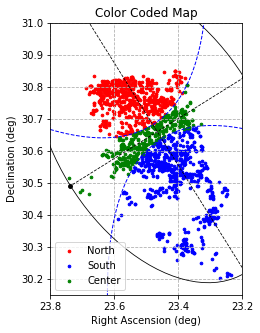

In [8]:
import math
from math import pi, cos, sin

#Display Data
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("Color Coded Map")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,31)
#ax.set_xlim(23,24)
#ax.set_ylim(30.2,31.2)
ax.invert_xaxis()
#ax.set_aspect(1/0.861)
ax.set_aspect("equal")
plt.grid(True,linestyle="--")

# Color code each regions
ax.scatter(df["RA"][NorthParabola],df["DEC"][NorthParabola],s=7,c="red",label="North")
ax.scatter(df["RA"][SouthParabola],df["DEC"][SouthParabola],s=7,c="blue",label="South")
ax.scatter(df["RA"][Center],df["DEC"][Center],s=7,c="green",label="Center")
plt.legend()

#-------------------------------------

#Fit Ellipse
u= center_RA       #x-position of the center
v= center_Dec    #y-position of the center
a= 0.52     #radius on the x-axis
b= 0.32      #radius on the y-axis
t_rot=math.radians(58) #rotation angle

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
     #u,v removed to keep the same center location
R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
     #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

plt.plot(u+Ell_rot[0,:] , v+Ell_rot[1,:],c='black',linewidth=0.8)    #rotated ellipse

#Semi-minor Axis
x_SMi_0 = center_RA + (b*cos(np.radians(32))) #x-coor of left Semi-minor axis point 
y_SMi_0 = center_Dec - (b*sin(np.radians(32))) #y-coor of left Semi-minor axis point
x_SMi_1 = center_RA - (b*cos(np.radians(32))) #x-coor of right Semi-minor axis point
y_SMi_1 = center_Dec + (b*sin(np.radians(32))) #y-coor of right Semi-minor axis point
plt.scatter(x_SMi_0,y_SMi_0,s=15,c="black")
plt.scatter(x_SMi_1,y_SMi_1,s=15,c="black")

m_SMi = (y_SMi_1-y_SMi_0)/(x_SMi_1-x_SMi_0) #slope of line through Semi-minor axis 
b_SMi = y_SMi_0 - (m_SMi*x_SMi_0) #y-inter of line through Semi-minor axis
x_SMi = np.linspace(x_SMi_1,x_SMi_0,1000) #x values of line through Semi-minor axis
y_SMi = linear_func(x_SMi,m_SMi,b_SMi) #y values of line through Semi-minor axis
plt.plot(x_SMi,y_SMi,c='black',linewidth=0.8,linestyle="--")

#Semi-major Axis
x_SouthSMa = center_RA - (a*np.sin(np.radians(32))) #x-coor of North Semi-major axis point
y_SouthSMa = center_Dec - (a*np.cos(np.radians(32))) #y-coor of Nouth Semi-major axis point
x_NorthSMa = center_RA + (a*np.sin(np.radians(32))) #x-coor of South Semi-major axis point
y_NorthSMa = center_Dec + (a*np.cos(np.radians(32))) #y-coor of South Semi-major axis point
plt.scatter(x_NorthSMa,y_NorthSMa,c="black",s=15)
plt.scatter(x_SouthSMa,y_SouthSMa,c="black",s=15)

m_SMa = (y_NorthSMa-y_SouthSMa)/(x_NorthSMa-x_SouthSMa) #slope of line through Semi-major axis
b_SMa = y_SouthSMa - (m_SMa*x_SouthSMa) #y-inter of line through Semi-major axis 
x_SMa = np.linspace(x_NorthSMa,x_SouthSMa,1000) #x values of line through Semi-major axis
y_SMa = linear_func(x_SMa,m_SMa,b_SMa) #y values of line through Semi-major axis
plt.plot(x_SMa,y_SMa,c='black',linewidth=0.8,linestyle="--")

NorthPara_XCoor = x_NorthSMa - ((19*a/20)*np.sin(np.radians(32))) #coordinates to move North parabola to
NorthPara_YCoor = linear_func(NorthPara_XCoor,m_SMa,b_SMa)

SouthPara_XCoor = x_SouthSMa + ((19*a/20)*np.sin(np.radians(32))) #coordinate to move South parabola to
SouthPara_YCoor = linear_func(SouthPara_XCoor,m_SMa,b_SMa)

#Fit Two Parabolas
theta = np.radians(-32) #degrees to tilt parabolas
t = np.linspace(-10,10,1000)
#x = (0.5*t)*np.cos(theta) - (t**2)*np.sin(theta) + x_2
#y = (0.5*t)*np.sin(theta) + (t**2)*np.cos(theta) + y_2
x_NorthPara = 0.5*(t*np.cos(theta) - (t**2)*np.sin(theta)) + NorthPara_XCoor #x values of North parabola
y_NorthPara = 0.5*(t*np.sin(theta) + (t**2)*np.cos(theta)) + NorthPara_YCoor #y values of North parabola
plt.plot(x_NorthPara,y_NorthPara,c="blue",linewidth=1,linestyle="--")
x_SouthPara = -0.5*(t*np.cos(theta) - (t**2)*np.sin(theta)) + SouthPara_XCoor #x values of South parabola
y_SouthPara = -0.5*(t*np.sin(theta) + (t**2)*np.cos(theta)) + SouthPara_YCoor #y values of South parabola
plt.plot(x_SouthPara,y_SouthPara,c="blue",linewidth=1,linestyle="--")

fig.set_figwidth(5)
fig.set_figheight(5)

### Histograms Using Velocity

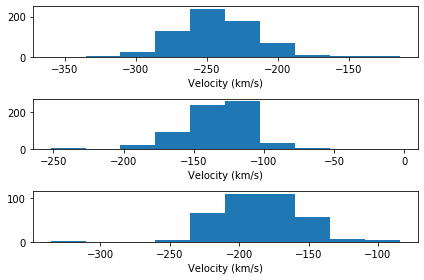

In [9]:
fig,ax = plt.subplots(3)
ax[0].hist(df["Velocity (km/s)"][NorthParabola])
ax[0].set_xlabel("Velocity (km/s)")

ax[1].hist(df["Velocity (km/s)"][SouthParabola])
ax[1].set_xlabel("Velocity (km/s)")

ax[2].hist(df["Velocity (km/s)"][Center])
ax[2].set_xlabel("Velocity (km/s)")

fig.tight_layout()

### Representing N,S,C as 0,1,2

In [10]:
def y_train():
    
    """
    Assign each datapoint a value based on its location
    0 = North, 1 = Center, 2 = South
    
    Returns
    ----------
    y_train: ndarray containing 0,1,2 corresponing to zones.
    """
    
    y_train = []
    for index in np.arange(len(df["Velocity (km/s)"])): #Sorting regions into 0,1,2 
        if index in np.where(NorthParabola==True)[0]:
            y_train.append(0)
        elif index in np.where(SouthParabola==True)[0]:
            y_train.append(2)
        else:
            y_train.append(1)
    
    return np.array(y_train)

In [11]:
true_val = y_train() 

In [12]:
print('Display TRUE results used to train the program:')
print(*true_val)

Display TRUE results used to train the program:
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 1 2 2 1 1 1 2 2 2 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 

### Neural Network and Training

In [13]:
#1688 datapoints
#1400 for training, 288 for testing
#x_train = np.array([Dist_RA[:1400],Dist_Dec[:1400]]).T
x_train = np.array([df["RA"][:1400],df["DEC"][:1400],df["Velocity (km/s)"][:1400]]).T
y_train = np.array(true_val[:1400],dtype="float")
x_test = np.array([df["RA"][1400:1689],df["DEC"][1400:1869],df["Velocity (km/s)"][1400:1689]]).T
y_test = np.array(true_val[1400:1689],dtype="float")

In [14]:
x_train = torch.tensor(x_train,dtype=torch.float) #ndarray to tensor
y_train = torch.tensor(y_train,dtype=torch.float) #ndarray to tensor
x_test = torch.tensor(x_test,dtype=torch.float) #ndarray to tensor
y_test = torch.tensor(y_test,dtype=torch.float) #ndarray to tensor

In [15]:
#Set up network, loss function, and optimizer
torch.manual_seed(123)
net = torch.nn.Sequential(torch.nn.Linear(3, 50),
    torch.nn.ReLU(),                      
    torch.nn.Linear(50, 50),                      
    torch.nn.ReLU(),                      
    torch.nn.Linear(50, 3),
) 

torch.save(net.state_dict(), 'net_FP.pth')

loss_func = torch.nn.CrossEntropyLoss() #Use CrossEntropyLoss as loss function
optimizer = torch.optim.Adam(net.parameters(),lr=0.1) #Use Adam optimizer with learning rate of 0.1

In [16]:
#Pack data
xy_train = torch.utils.data.TensorDataset(x_train, y_train)

#Unpack data
loader = torch.utils.data.DataLoader(xy_train, batch_size=1400, shuffle=True)

In [17]:
losses_train, losses_test = [],[]
for epoch in np.arange(200): #training loop. Run for 200 epochs
    for x_batch,y_batch in loader:
        net.train() 
        y_batch = y_batch.type(torch.LongTensor)
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_func(y_pred,y_batch)
        loss.backward()
        optimizer.step()
    losses_train.append(loss.data)
        
    net.eval()
    y_test = y_test.type(torch.LongTensor)
    y_pred = net(x_test)
    loss = loss_func(y_pred,y_test)
    losses_test.append(loss.data)

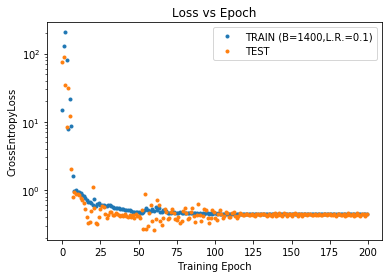

In [18]:
plt.plot(losses_train, '.', label="TRAIN (B=1400,L.R.=0.1)")
plt.plot(losses_test, '.',label="TEST")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('CrossEntropyLoss')
plt.title("Loss vs Epoch")
plt.yscale('log')

## Use NN To Classify Data Points

In [19]:
All_Data = np.array([df["RA"],df["DEC"],df["Velocity (km/s)"]]).T
All_Data = torch.tensor(All_Data,dtype=torch.float)
Predicted_Data = net(All_Data)

In [20]:
print("Predicted Results: ", Predicted_Data)

Predicted Results:  tensor([[-1.3453,  0.6811,  2.2252],
        [-1.2050, -0.0086,  3.1098],
        [-1.3983,  0.9102,  1.9409],
        ...,
        [ 2.9435,  1.2839, -0.8206],
        [ 2.7264,  1.3434, -0.7531],
        [ 2.0201,  1.5369, -0.5335]], grad_fn=<AddmmBackward>)


In [21]:
max_index = torch.argmax(Predicted_Data,dim=1).numpy()
pairs_index = list(zip(max_index,true_val))

## Confusion Matrix

In [22]:
import pandas as pd
table = np.zeros((3,3)) #Create a 3x3 table of zero
for pair in pairs_index: #Add one to their respective element when their respective pair is identify
    if pair == (0,0):
        table[0,0] += 1
    elif pair == (1,0):
        table[1,0] += 1
    elif pair == (2,0):
        table[2,0] += 1
    elif pair == (0,1):
        table[0,1] += 1
    elif pair == (1,1):
        table[1,1] += 1
    elif pair == (2,1):
        table[2,1] += 1
    elif pair == (0,2):
        table[0,2] += 1
    elif pair == (1,2):
        table[1,2] += 1
    elif pair == (2,2):
        table[2,2] += 1

df_CM = pd.DataFrame(table,columns=[0,1,2],index=[0,1,2]) #Create DataFrame for Confusion Matrx
Acc = (df_CM[0][0]+df_CM[1][1]+df_CM[2][2])/(df_CM.to_numpy().sum())
Err_Rate = (df_CM[0][1]+df_CM[0][2]+df_CM[1][0]+df_CM[1][2]+df_CM[2][0]+df_CM[2][1])/(df_CM.to_numpy().sum())
print("Confusion Matrix \nX-Axis = True Value \nY-Axis = Predicted Value \nAccuracy = {0} \nError Rate = {1}".format(Acc,Err_Rate)) #Print axis label
df_CM

Confusion Matrix 
X-Axis = True Value 
Y-Axis = Predicted Value 
Accuracy = 0.8009478672985783 
Error Rate = 0.1990521327014218


,0,1,2
0,567.0,64.0,9.0
1,91.0,218.0,88.0
2,8.0,76.0,567.0


## Visualization of NN Prediction

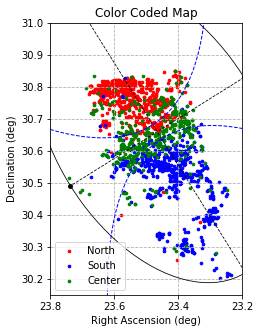

In [23]:
import math
from math import pi, cos, sin

#Display Data
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("Color Coded Map")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,31)
#ax.set_xlim(23,24)
#ax.set_ylim(30.2,31.2)
ax.invert_xaxis()
#ax.set_aspect(1/0.861)
ax.set_aspect("equal")
plt.grid(True,linestyle="--")

# Color code each regions
ML_Prediction_North = np.where(max_index == 0)
ML_Prediction_Center = np.where(max_index == 1)
ML_Prediction_South = np.where(max_index == 2)
ax.scatter(df["RA"][ML_Prediction_North[0]],df["DEC"][ML_Prediction_North[0]],s=7,c="red",label="North")
ax.scatter(df["RA"][ML_Prediction_South[0]],df["DEC"][ML_Prediction_South[0]],s=7,c="blue",label="South")
ax.scatter(df["RA"][ML_Prediction_Center[0]],df["DEC"][ML_Prediction_Center[0]],s=7,c="green",label="Center")
plt.legend()

#-------------------------------------

#Fit Ellipse
u= center_RA       #x-position of the center
v= center_Dec    #y-position of the center
a= 0.52     #radius on the x-axis
b= 0.32      #radius on the y-axis
t_rot=math.radians(58) #rotation angle

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
     #u,v removed to keep the same center location
R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
     #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

plt.plot(u+Ell_rot[0,:] , v+Ell_rot[1,:],c='black',linewidth=0.8)    #rotated ellipse

#Semi-minor Axis
x_SMi_0 = center_RA + (b*cos(np.radians(32))) #x-coor of left Semi-minor axis point 
y_SMi_0 = center_Dec - (b*sin(np.radians(32))) #y-coor of left Semi-minor axis point
x_SMi_1 = center_RA - (b*cos(np.radians(32))) #x-coor of right Semi-minor axis point
y_SMi_1 = center_Dec + (b*sin(np.radians(32))) #y-coor of right Semi-minor axis point
plt.scatter(x_SMi_0,y_SMi_0,s=15,c="black")
plt.scatter(x_SMi_1,y_SMi_1,s=15,c="black")

m_SMi = (y_SMi_1-y_SMi_0)/(x_SMi_1-x_SMi_0) #slope of line through Semi-minor axis 
b_SMi = y_SMi_0 - (m_SMi*x_SMi_0) #y-inter of line through Semi-minor axis
x_SMi = np.linspace(x_SMi_1,x_SMi_0,1000) #x values of line through Semi-minor axis
y_SMi = linear_func(x_SMi,m_SMi,b_SMi) #y values of line through Semi-minor axis
plt.plot(x_SMi,y_SMi,c='black',linewidth=0.8,linestyle="--")

#Semi-major Axis
x_SouthSMa = center_RA - (a*np.sin(np.radians(32))) #x-coor of North Semi-major axis point
y_SouthSMa = center_Dec - (a*np.cos(np.radians(32))) #y-coor of Nouth Semi-major axis point
x_NorthSMa = center_RA + (a*np.sin(np.radians(32))) #x-coor of South Semi-major axis point
y_NorthSMa = center_Dec + (a*np.cos(np.radians(32))) #y-coor of South Semi-major axis point
plt.scatter(x_NorthSMa,y_NorthSMa,c="black",s=15)
plt.scatter(x_SouthSMa,y_SouthSMa,c="black",s=15)

m_SMa = (y_NorthSMa-y_SouthSMa)/(x_NorthSMa-x_SouthSMa) #slope of line through Semi-major axis
b_SMa = y_SouthSMa - (m_SMa*x_SouthSMa) #y-inter of line through Semi-major axis 
x_SMa = np.linspace(x_NorthSMa,x_SouthSMa,1000) #x values of line through Semi-major axis
y_SMa = linear_func(x_SMa,m_SMa,b_SMa) #y values of line through Semi-major axis
plt.plot(x_SMa,y_SMa,c='black',linewidth=0.8,linestyle="--")

NorthPara_XCoor = x_NorthSMa - ((19*a/20)*np.sin(np.radians(32))) #coordinates to move North parabola to
NorthPara_YCoor = linear_func(NorthPara_XCoor,m_SMa,b_SMa)

SouthPara_XCoor = x_SouthSMa + ((19*a/20)*np.sin(np.radians(32))) #coordinate to move South parabola to
SouthPara_YCoor = linear_func(SouthPara_XCoor,m_SMa,b_SMa)

#Fit Two Parabolas
theta = np.radians(-32) #degrees to tilt parabolas
t = np.linspace(-10,10,1000)
#x = (0.5*t)*np.cos(theta) - (t**2)*np.sin(theta) + x_2
#y = (0.5*t)*np.sin(theta) + (t**2)*np.cos(theta) + y_2
x_NorthPara = 0.5*(t*np.cos(theta) - (t**2)*np.sin(theta)) + NorthPara_XCoor #x values of North parabola
y_NorthPara = 0.5*(t*np.sin(theta) + (t**2)*np.cos(theta)) + NorthPara_YCoor #y values of North parabola
plt.plot(x_NorthPara,y_NorthPara,c="blue",linewidth=1,linestyle="--")
x_SouthPara = -0.5*(t*np.cos(theta) - (t**2)*np.sin(theta)) + SouthPara_XCoor #x values of South parabola
y_SouthPara = -0.5*(t*np.sin(theta) + (t**2)*np.cos(theta)) + SouthPara_YCoor #y values of South parabola
plt.plot(x_SouthPara,y_SouthPara,c="blue",linewidth=1,linestyle="--")

fig.set_figwidth(5)
fig.set_figheight(5)